In [0]:
import os
os.listdir("./drive/My Drive/Colab Notebooks")

['Untitled0.ipynb', 'ks-projects-201801.csv']

In [0]:
import pandas as pd

# parse 한부분은 나중에 사용하기위해서
ks = pd.read_csv('./drive/My Drive/Colab Notebooks/ks-projects-201801.csv',parse_dates=['deadline', 'launched'])
ks.head(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


In [0]:
pd.unique(ks.state)

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [0]:
ks.groupby('state')['ID'].count()

state
canceled       38779
failed        197719
live            2799
successful    133956
suspended       1846
undefined       3562
Name: ID, dtype: int64

In [0]:
# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

In [0]:
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,outcome,hour,day,month,year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0,12,11,8,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0,4,2,9,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0,0,12,1,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0,3,17,3,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,0,8,4,7,2015


In [0]:
from sklearn.preprocessing import LabelEncoder
#문자값들을 int값으로 변환
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()

# Apply the label encoder to each column
encoded = ks[cat_features].apply(encoder.fit_transform)
encoded.head(10)

,category,currency,country
0,108,5,9
1,93,13,22
2,93,13,22
3,90,13,22
4,55,13,22
5,123,13,22
6,58,13,22
7,41,13,22
8,113,13,22
9,39,13,22


In [0]:
# Since ks and encoded have the same index and I can easily join them
data = ks[['goal', 'hour', 'day', 'month', 'year', 'outcome']].join(encoded)
data.head()

,goal,hour,day,month,year,outcome,category,currency,country
0,1000.0,12,11,8,2015,0,108,5,9
1,30000.0,4,2,9,2017,0,93,13,22
2,45000.0,0,12,1,2013,0,93,13,22
3,5000.0,3,17,3,2012,0,90,13,22
4,19500.0,8,4,7,2015,0,55,13,22


In [0]:
valid_fraction = 0.1
valid_size = int(len(data) * valid_fraction)

train = data[:-2 * valid_size] #80퍼
valid = data[-2 * valid_size:-valid_size]#10퍼
test = data[-valid_size:]#10퍼

In [0]:
for each in [train, valid, test]:
    print(f"Outcome fraction = {each.outcome.mean():.4f}")

Outcome fraction = 0.3570
Outcome fraction = 0.3539
Outcome fraction = 0.3542


In [0]:
import lightgbm as lgb

feature_cols = train.columns.drop('outcome')

dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

In [0]:
from sklearn import metrics
ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['outcome'], ypred)

print(f"Test AUC score: {score}")

Test AUC score: 0.747615303004287


In [0]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

ks = pd.read_csv('./drive/My Drive/Colab Notebooks/ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

In [0]:
# Defining  functions that will help us test our encodings
import lightgbm as lgb
from sklearn import metrics

def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')

    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    print("Training model!")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    print(f"Validation AUC score: {valid_score:.4f}")
    return bst

In [0]:
# Training a model on the baseline data
train, valid, _ = get_data_splits(baseline_data)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7467


In [0]:
import category_encoders as ce
cat_features = ['category', 'currency', 'country']
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(ks[cat_features])

data = baseline_data.join(count_encoded.add_suffix("_count"))

# Training a model on the baseline data
train, valid, test = get_data_splits(data)
bst = train_model(train, valid)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Training model!
Validation AUC score: 0.7486


In [0]:
import category_encoders as ce
cat_features = ['category', 'currency', 'country']

# Create the encoder itself
target_enc = ce.TargetEncoder(cols=cat_features)

train, valid, _ = get_data_splits(data)

# Fit the encoder using the categorical features and target
target_enc.fit(train[cat_features], train['outcome'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
train = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

train.head()
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7491


In [68]:
!pip install category_encoders

     |████████████████████████████████| 81kB 5.7MB/s 


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import LabelEncoder

ks = pd.read_csv('./drive/My Drive/Colab Notebooks/ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

In [0]:
interactions = ks['category'] + "_" + ks['country']
print(interactions.head(10))

0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
5       Restaurants_US
6              Food_US
7            Drinks_US
8    Product Design_US
9       Documentary_US
dtype: object


In [0]:
label_enc = LabelEncoder()
data_interaction = baseline_data.assign(category_country=label_enc.fit_transform(interactions))
data_interaction.head()

,goal,hour,day,month,year,outcome,category,currency,country,category_country
0,1000.0,12,11,8,2015,0,108,5,9,1900
1,30000.0,4,2,9,2017,0,93,13,22,1630
2,45000.0,0,12,1,2013,0,93,13,22,1630
3,5000.0,3,17,3,2012,0,90,13,22,1595
4,19500.0,8,4,7,2015,0,55,13,22,979


In [0]:
# First, create a Series with a timestamp index
launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
launched.head(20)

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
2009-04-25 17:36:21    325391
2009-04-27 14:10:39    122662
2009-04-28 13:55:41    213711
2009-04-29 02:04:21    345606
2009-04-29 02:58:50    235255
2009-04-29 04:37:37     98954
2009-04-29 05:26:32    342226
2009-04-29 06:43:44    275091
2009-04-29 13:52:03    284115
2009-04-29 22:08:13     32898
Name: count_7_days, dtype: int64

launched
1970-01-01 01:00:00     0.0
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
1970-01-01 01:00:00     6.0
2009-04-21 21:02:48     0.0
2009-04-23 00:07:53     1.0
2009-04-24 21:52:03     2.0
2009-04-25 17:36:21     3.0
2009-04-27 14:10:39     4.0
2009-04-28 13:55:41     5.0
2009-04-29 02:04:21     5.0
2009-04-29 02:58:50     6.0
2009-04-29 04:37:37     7.0
2009-04-29 05:26:32     8.0
2009-04-29 06:43:44     9.0
2009-04-29 13:52:03    10.0
2009-04-29 22:08:13    11.0
Name: count_7_days, dtype: float64


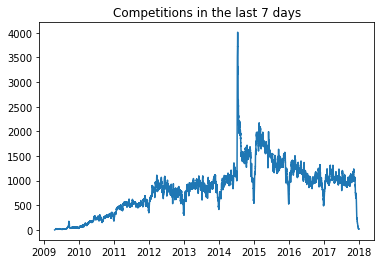

In [0]:
count_7_days = launched.rolling('7d').count() - 1
print(count_7_days.head(20))

# Ignore records with broken launch dates
plt.plot(count_7_days[7:]);
plt.title("Competitions in the last 7 days");

In [0]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)

In [0]:
count_7_days.head(10)

0    1409.0
1     957.0
2     739.0
3     907.0
4    1429.0
5    1284.0
6    1119.0
7    1391.0
8    1043.0
9    3199.0
Name: count_7_days, dtype: float64

In [0]:
baseline_data.join(count_7_days).head(10)

,goal,hour,day,month,year,outcome,category,currency,country,count_7_days
0,1000.0,12,11,8,2015,0,108,5,9,1409.0
1,30000.0,4,2,9,2017,0,93,13,22,957.0
2,45000.0,0,12,1,2013,0,93,13,22,739.0
3,5000.0,3,17,3,2012,0,90,13,22,907.0
4,19500.0,8,4,7,2015,0,55,13,22,1429.0
5,50000.0,13,26,2,2016,1,123,13,22,1284.0
6,1000.0,18,1,12,2014,1,58,13,22,1119.0
7,25000.0,20,1,2,2016,0,41,13,22,1391.0
8,125000.0,18,24,4,2014,0,113,13,22,1043.0
9,65000.0,21,11,7,2014,0,39,13,22,3199.0


In [0]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(20)

,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN
2842,0.000000
273779,NaN
169268,NaN
322000,NaN
138572,NaN


In [0]:
# Final time since last project
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(baseline_data.index)
timedeltas.head(20)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


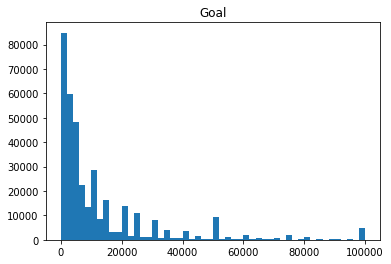

In [0]:
plt.hist(ks.goal, range=(0, 100000), bins=50);
plt.title('Goal');

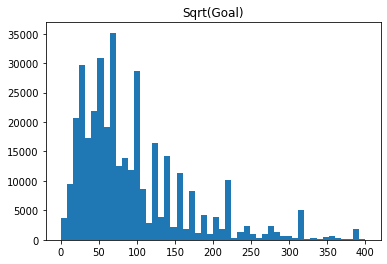

In [0]:
plt.hist(np.sqrt(ks.goal), range=(0, 400), bins=50);
plt.title('Sqrt(Goal)');

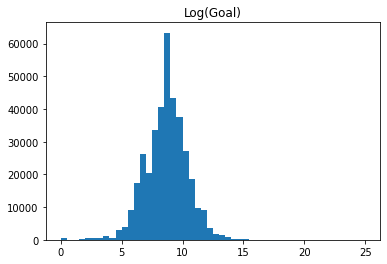

In [0]:
plt.hist(np.log(ks.goal), range=(0, 25), bins=50);
plt.title('Log(Goal)');

In [0]:
%matplotlib inline

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

ks = pd.read_csv('./drive/My Drive/Colab Notebooks/ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

cat_features = ['category', 'currency', 'country']
interactions = pd.DataFrame(index=ks.index)
for col1, col2 in itertools.combinations(cat_features, 2):
    new_col_name = '_'.join([col1, col2])
    # Convert to strings and combine
    new_values = ks[col1].map(str) + "_" + ks[col2].map(str)
    label_enc = LabelEncoder()
    interactions[new_col_name] = label_enc.fit_transform(new_values)
baseline_data = baseline_data.join(interactions)

launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
count_7_days = launched.rolling('7d').count() - 1
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)

baseline_data = baseline_data.join(count_7_days)

def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas = timedeltas.fillna(timedeltas.max())

baseline_data = baseline_data.join(timedeltas.rename({'launched': 'time_since_last_project'}, axis=1))

def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')

    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    print("Training model!")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    print(f"Validation AUC score: {valid_score:.4f}")
    return bst

In [0]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_cols = baseline_data.columns.drop('outcome')

# Keep 5 features
selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(baseline_data[feature_cols], baseline_data['outcome'])
X_new

array([[2015.,    5.,    9.,   18., 1409.],
       [2017.,   13.,   22.,   31.,  957.],
       [2013.,   13.,   22.,   31.,  739.],
       ...,
       [2010.,   13.,   22.,   31.,  238.],
       [2016.,   13.,   22.,   31., 1100.],
       [2011.,   13.,   22.,   31.,  542.]])

In [0]:
feature_cols = baseline_data.columns.drop('outcome')
train, valid, _ = get_data_splits(baseline_data)

# Keep 5 features
selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(train[feature_cols], train['outcome'])
X_new

array([[2.015e+03, 5.000e+00, 9.000e+00, 1.800e+01, 1.409e+03],
       [2.017e+03, 1.300e+01, 2.200e+01, 3.100e+01, 9.570e+02],
       [2.013e+03, 1.300e+01, 2.200e+01, 3.100e+01, 7.390e+02],
       ...,
       [2.011e+03, 1.300e+01, 2.200e+01, 3.100e+01, 5.150e+02],
       [2.015e+03, 1.000e+00, 3.000e+00, 2.000e+00, 1.306e+03],
       [2.013e+03, 1.300e+01, 2.200e+01, 3.100e+01, 1.084e+03]])

In [0]:
# Get back the features we've kept, zero out all other features
selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=feature_cols)
selected_features.head()

,goal,hour,day,month,year,category,currency,country,category_currency,category_country,currency_country,count_7_days,time_since_last_project
0,0.0,0.0,0.0,0.0,2015.0,0.0,5.0,9.0,0.0,0.0,18.0,1409.0,0.0
1,0.0,0.0,0.0,0.0,2017.0,0.0,13.0,22.0,0.0,0.0,31.0,957.0,0.0
2,0.0,0.0,0.0,0.0,2013.0,0.0,13.0,22.0,0.0,0.0,31.0,739.0,0.0
3,0.0,0.0,0.0,0.0,2012.0,0.0,13.0,22.0,0.0,0.0,31.0,907.0,0.0
4,0.0,0.0,0.0,0.0,2015.0,0.0,13.0,22.0,0.0,0.0,31.0,1429.0,0.0


In [0]:
# Dropped columns have values of all 0s, so var is 0, drop them
selected_columns = selected_features.columns[selected_features.var() != 0]

# Get the valid dataset with the selected features.
valid[selected_columns].head()

,year,currency,country,currency_country,count_7_days
302896,2015,13,22,31,1534.0
302897,2013,13,22,31,625.0
302898,2014,5,9,18,851.0
302899,2014,13,22,31,1973.0
302900,2014,5,9,18,2163.0


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

train, valid, _ = get_data_splits(baseline_data)

X, y = train[train.columns.drop("outcome")], train['outcome']

# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1",solver='liblinear', random_state=7).fit(X, y)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)
X_new

array([[1.000e+03, 1.200e+01, 1.100e+01, ..., 1.900e+03, 1.800e+01,
        1.409e+03],
       [3.000e+04, 4.000e+00, 2.000e+00, ..., 1.630e+03, 3.100e+01,
        9.570e+02],
       [4.500e+04, 0.000e+00, 1.200e+01, ..., 1.630e+03, 3.100e+01,
        7.390e+02],
       ...,
       [2.500e+03, 0.000e+00, 3.000e+00, ..., 1.830e+03, 3.100e+01,
        5.150e+02],
       [2.600e+03, 2.100e+01, 2.300e+01, ..., 1.036e+03, 2.000e+00,
        1.306e+03],
       [2.000e+04, 1.600e+01, 4.000e+00, ..., 9.200e+02, 3.100e+01,
        1.084e+03]])

In [0]:
# Get back the kept features as a DataFrame with dropped columns as all 0s
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X.index,
                                 columns=X.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]

In [120]:
import pandas as pd
ks = pd.read_csv('./drive/My Drive/Colab Notebooks/US_WeatherEvents_2016-2019.csv',parse_dates=['StartTime(UTC)','EndTime(UTC)'])
ks.head(10)

,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
5,W-6,Snow,Light,2016-01-08 16:14:00,2016-01-08 17:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
6,W-7,Fog,Severe,2016-01-09 12:54:00,2016-01-09 15:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
7,W-8,Snow,Light,2016-01-09 15:34:00,2016-01-09 16:14:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
8,W-9,Fog,Severe,2016-01-09 16:14:00,2016-01-09 16:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
9,W-10,Snow,Light,2016-01-09 16:34:00,2016-01-09 16:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


In [111]:
pd.unique(ks.Type)

array(['Snow', 'Fog', 'Cold', 'Storm', 'Rain', 'Precipitation', 'Hail'],
      dtype=object)

In [44]:
ks.groupby('schoolsup')['sex'].count()

schoolsup
no     344
yes     51
Name: sex, dtype: int64

In [121]:
ks = ks.assign(outcome=(ks['Type'] == 'Snow').astype(int))
ks.head()

,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode,outcome
0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1
1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1
2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1
3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1
4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1


In [122]:
ks.rename(columns={ks.columns[3]:'StartTime'},inplace=True)
ks.head()

,EventId,Type,Severity,StartTime,EndTime(UTC),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode,outcome
0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1
1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1
2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1
3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1
4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1


In [123]:
ks = ks.assign(hour=ks.StartTime.dt.hour,
               day=ks.StartTime.dt.day,
               month=ks.StartTime.dt.month,
               year=ks.StartTime.dt.year)

ks.head()

,EventId,Type,Severity,StartTime,EndTime(UTC),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode,outcome,hour,day,month,year
0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1,23,6,1,2016
1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1,4,7,1,2016
2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1,5,7,1,2016
3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1,5,8,1,2016
4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0,1,13,8,1,2016


In [127]:
type(ks['City'][0])

str

In [131]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()  # sklearn 의 encoder
cat_features = ['County','State']

# Apply the label encoder to each column
encoded = ks[cat_features].apply(encoder.fit_transform)
encoded.head(10)

,County,State
0,850,4
1,850,4
2,850,4
3,850,4
4,850,4
5,850,4
6,850,4
7,850,4
8,850,4
9,850,4


In [132]:
data=ks[[ 'hour', 'day', 'month', 'year','outcome']].join(encoded)
data.head()

,hour,day,month,year,outcome,County,State
0,23,6,1,2016,1,850,4
1,4,7,1,2016,1,850,4
2,5,7,1,2016,1,850,4
3,5,8,1,2016,1,850,4
4,13,8,1,2016,1,850,4


In [0]:
valid_fraction = 0.1
valid_size = int(len(data) * valid_fraction)

train = data[:-2 * valid_size]
valid = data[-2 * valid_size:-valid_size]
test = data[-valid_size:]

In [0]:
import lightgbm as lgb

feature_cols = train.columns.drop('outcome')

dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

In [135]:
from sklearn import metrics
ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['outcome'], ypred)

print(f"Test AUC score: {score}")

Test AUC score: 0.9254568376981384


In [145]:
cat_features = ['County','State']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['outcome','hour', 'day', 'month', 'year']
baseline_data = ks[data_cols].join(encoded)
baseline_data.head()

,outcome,hour,day,month,year,County,State
0,1,23,6,1,2016,850,4
1,1,4,7,1,2016,850,4
2,1,5,7,1,2016,850,4
3,1,5,8,1,2016,850,4
4,1,13,8,1,2016,850,4


In [0]:
import lightgbm as lgb
from sklearn import metrics

def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')

    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    print("Training model!")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    print(f"Validation AUC score: {valid_score:.4f}")
    return bst

In [147]:
train, valid, _ = get_data_splits(baseline_data)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.9449


In [148]:
import category_encoders as ce

cat_features = ['County','State']
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(ks[cat_features])

data = baseline_data.join(count_encoded.add_suffix("_count"))

# Training a model on the baseline data
train, valid, test = get_data_splits(data)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.9425


In [149]:
import category_encoders as ce
cat_features = ['County','State']

# Create the encoder itself
target_enc = ce.TargetEncoder(cols=cat_features)

train, valid, _ = get_data_splits(data)

# Fit the encoder using the categorical features and target
target_enc.fit(train[cat_features], train['outcome'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
train = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

train.head()
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.9162


In [150]:
cat_features = ['County','State']
target_enc = ce.CatBoostEncoder(cols=cat_features)

train, valid, _ = get_data_splits(data)
target_enc.fit(train[cat_features], train['outcome'])

train = train.join(target_enc.transform(train[cat_features]).add_suffix('_cb'))
valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_cb'))

bst = train_model(train, valid)

Training model!
Validation AUC score: 0.9183


In [151]:
interactions = ks['County'] + "_" + ks['State']
print(interactions.head(10))

0    Saguache_CO
1    Saguache_CO
2    Saguache_CO
3    Saguache_CO
4    Saguache_CO
5    Saguache_CO
6    Saguache_CO
7    Saguache_CO
8    Saguache_CO
9    Saguache_CO
dtype: object


In [152]:
label_enc = LabelEncoder()
data_interaction = baseline_data.assign(category_country=label_enc.fit_transform(interactions))
data_interaction.head()

,outcome,hour,day,month,year,County,State,category_country
0,1,23,6,1,2016,850,4,1199
1,1,4,7,1,2016,850,4,1199
2,1,5,7,1,2016,850,4,1199
3,1,5,8,1,2016,850,4,1199
4,1,13,8,1,2016,850,4,1199


In [153]:
launched = pd.Series(ks.index, index=ks.StartTime, name="count_7_days").sort_index()
launched.head(20)

StartTime
2016-01-01 05:00:00    2141597
2016-01-01 05:00:00    2232154
2016-01-01 05:00:00     402900
2016-01-01 05:01:00     182693
2016-01-01 05:02:00    2327296
2016-01-01 05:04:00     760031
2016-01-01 05:05:00    3301856
2016-01-01 05:06:00    2247473
2016-01-01 05:08:00    1411608
2016-01-01 05:12:00    1688286
2016-01-01 05:13:00     646034
2016-01-01 05:14:00    4130550
2016-01-01 05:14:00    4309932
2016-01-01 05:14:00    4276277
2016-01-01 05:15:00    4708659
2016-01-01 05:15:00     506229
2016-01-01 05:15:00    4126660
2016-01-01 05:15:00    1615860
2016-01-01 05:15:00    2252669
2016-01-01 05:15:00    4145825
Name: count_7_days, dtype: int64

StartTime
2016-01-01 05:00:00     0.0
2016-01-01 05:00:00     1.0
2016-01-01 05:00:00     2.0
2016-01-01 05:01:00     3.0
2016-01-01 05:02:00     4.0
2016-01-01 05:04:00     5.0
2016-01-01 05:05:00     6.0
2016-01-01 05:06:00     7.0
2016-01-01 05:08:00     8.0
2016-01-01 05:12:00     9.0
2016-01-01 05:13:00    10.0
2016-01-01 05:14:00    11.0
2016-01-01 05:14:00    12.0
2016-01-01 05:14:00    13.0
2016-01-01 05:15:00    14.0
2016-01-01 05:15:00    15.0
2016-01-01 05:15:00    16.0
2016-01-01 05:15:00    17.0
2016-01-01 05:15:00    18.0
2016-01-01 05:15:00    19.0
Name: count_7_days, dtype: float64


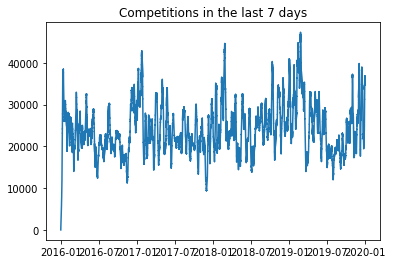

In [155]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
count_7_days = launched.rolling('7d').count() - 1
print(count_7_days.head(20))

# Ignore records with broken launch dates
plt.plot(count_7_days[7:]);
plt.title("Competitions in the last 7 days");

In [0]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)

In [158]:
count_7_days.head(10)

0    12838.0
1    14136.0
2    14608.0
3    21155.0
4    22937.0
5    23520.0
6    29138.0
7    29906.0
8    30110.0
9    30192.0
Name: count_7_days, dtype: float64

In [159]:
baseline_data.join(count_7_days).head(10)

,outcome,hour,day,month,year,County,State,count_7_days
0,1,23,6,1,2016,850,4,12838.0
1,1,4,7,1,2016,850,4,14136.0
2,1,5,7,1,2016,850,4,14608.0
3,1,5,8,1,2016,850,4,21155.0
4,1,13,8,1,2016,850,4,22937.0
5,1,16,8,1,2016,850,4,23520.0
6,0,12,9,1,2016,850,4,29138.0
7,1,15,9,1,2016,850,4,29906.0
8,0,16,9,1,2016,850,4,30110.0
9,1,16,9,1,2016,850,4,30192.0


In [160]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.

df = ks[['County', 'StartTime']].sort_values('StartTime')
timedeltas = df.groupby('County').transform(time_since_last_project)
timedeltas.head(20)

,StartTime
2141597,NaN
2232154,NaN
402900,NaN
182693,NaN
2327296,NaN
760031,NaN
3301856,NaN
2247473,NaN
1411608,NaN
1688286,NaN


In [161]:
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(baseline_data.index)
timedeltas.head(20)

,StartTime
0,1.000000
1,5.000000
2,1.666667
3,23.666667
4,8.333333
5,2.333333
6,20.666667
7,2.666667
8,0.666667
9,0.333333


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


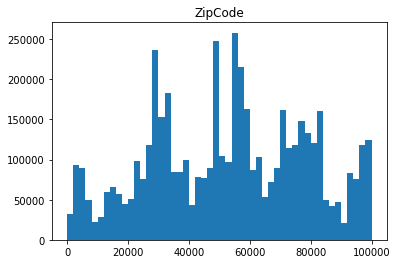

In [163]:
plt.hist(ks.ZipCode, range=(0, 100000), bins=50);
plt.title('ZipCode');

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


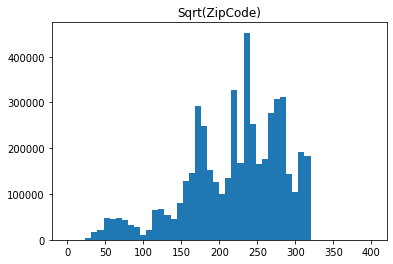

In [164]:
plt.hist(np.sqrt(ks.ZipCode), range=(0, 400), bins=50);
plt.title('Sqrt(ZipCode)');

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


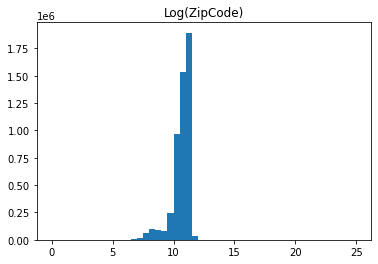

In [165]:
plt.hist(np.log(ks.ZipCode), range=(0, 25), bins=50);
plt.title('Log(ZipCode)');

In [166]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_cols = baseline_data.columns.drop('outcome')

# Keep 5 features
selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(baseline_data[feature_cols], baseline_data['outcome'])
X_new

array([[  23,    6,    1, 2016,    4],
       [   4,    7,    1, 2016,    4],
       [   5,    7,    1, 2016,    4],
       ...,
       [  12,   28,   12, 2019,   47],
       [  13,   28,   12, 2019,   47],
       [  17,   28,   12, 2019,   47]])

In [173]:
feature_cols = baseline_data.columns.drop('outcome')
train, valid, _ = get_data_splits(baseline_data)

# Keep 5 features
selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(train[feature_cols], train['outcome'])
X_new

bst = train_model(train, valid)

Training model!
Validation AUC score: 0.9449


In [168]:
selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=feature_cols)
selected_features.head()

,hour,day,month,year,County,State
0,0,6,1,2016,850,4
1,0,7,1,2016,850,4
2,0,7,1,2016,850,4
3,0,8,1,2016,850,4
4,0,8,1,2016,850,4


In [169]:
# Dropped columns have values of all 0s, so var is 0, drop them
selected_columns = selected_features.columns[selected_features.var() != 0]

# Get the valid dataset with the selected features.
valid[selected_columns].head()

,day,month,year,County,State
4047867,16,11,2018,334,19
4047868,16,11,2018,334,19
4047869,16,11,2018,334,19
4047870,16,11,2018,334,19
4047871,16,11,2018,334,19


In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

train, valid, _ = get_data_splits(baseline_data)

X, y = train[train.columns.drop("outcome")], train['outcome']

# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", solver='liblinear',random_state=7).fit(X, y)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)
X_new

Training model!
Validation AUC score: 0.9449


In [0]:
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X.index,
                                 columns=X.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]